In [ ]:
!pip install wfdb numpy pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 99.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


##신호 데이터 확인

In [ ]:
import wfdb
import pandas as pd
from pathlib import Path
import sys

# --- [ 1. 사용자 설정 ] ---
# [수정 필요] .hea, .dat 파일이 있는 최상위 폴더 경로
# 예: /content/drive/MyDrive/CPSC_2021_Original/
ROOT_DIR = Path("./분류_Training_set_I")
# --------------------------


def analyze_records(root_dir: Path):
    """지정된 폴더 내의 모든 WFDB 레코드 구조를 분석하고 요약합니다."""

    if not root_dir.exists():
        print(f"[오류] 지정된 경로를 찾을 수 없습니다: {root_dir}")
        print("스크립트 상단의 'ROOT_DIR' 경로를 올바르게 수정해주세요.")
        sys.exit(1)

    # 1. 하위 폴더를 포함하여 모든 .hea 파일 검색
    print(f"'{root_dir}' 폴더에서 .hea 파일 검색 중...")
    hea_files = sorted(list(root_dir.rglob("*.hea")))

    if not hea_files:
        print("[오류] .hea 파일을 찾을 수 없습니다. 경로를 확인하세요.")
        return

    print(f"총 {len(hea_files)}개의 레코드를 찾았습니다. 분석을 시작합니다.\n")

    results = []

    # 2. 각 파일을 순회하며 정보 읽기
    for hea_file in hea_files:
        try:
            # 예: /.../data_0_1.hea -> /.../data_0_1
            record_stem_path = str(hea_file.with_suffix(''))

            # 헤더 읽기
            record = wfdb.rdheader(record_stem_path)

            # 신호 길이 (초) 계산
            duration_sec = record.sig_len / record.fs

            # 결과 저장
            results.append({
                "file": hea_file.relative_to(root_dir),
                "fs": record.fs,
                "sig_len": record.sig_len,
                "n_sig": record.n_sig,
                "duration_sec": duration_sec
            })

            # 개별 파일 정보 출력
            print(f"--- 파일: {hea_file.relative_to(root_dir)} ---")
            print(f"  - 샘플링 주파수 (fs): {record.fs} Hz")
            print(f"  - 총 샘플 수 (sig_len): {record.sig_len} 샘플")
            print(f"  - 채널 수 (n_sig): {record.n_sig}")
            print(f"  - 신호 길이 (Duration): {duration_sec:.2f} 초")

        except Exception as e:
            print(f"[경고] {hea_file.name} 파일 읽기 실패: {e}")

    # 3. 전체 결과 요약
    if not results:
        print("\n[완료] 분석할 유효한 파일이 없습니다.")
        return

    print("\n\n" + "="*30)
    print("      데이터 구조 전체 요약")
    print("="*30)

    df = pd.DataFrame(results)

    # 샘플링 주파수(fs) 요약
    print("\n📊 [샘플링 주파수 (fs) 분포]")
    print(df['fs'].value_counts().to_markdown())

    # 채널 수(n_sig) 요약
    print("\n📊 [채널 수 (n_sig) 분포]")
    print(df['n_sig'].value_counts().to_markdown())

    # 신호 길이(Duration) 요약 (통계)
    print("\n📊 [신호 길이 (초) 통계]")
    print(df['duration_sec'].describe().to_markdown(floatfmt=".2f"))

    # ✅ 전체 신호 길이(합계) 출력
    total_sig_len = df['sig_len'].sum()          # 모든 파일 샘플 수 합
    total_duration_sec = df['duration_sec'].sum()  # 모든 파일 시간(초) 합

    print("\n📊 [전체 신호 길이 합계]")
    print(f"- 총 샘플 수: {total_sig_len} 샘플")
    print(f"- 총 길이: {total_duration_sec:.2f} 초 (약 {total_duration_sec/60:.2f} 분, {total_duration_sec/3600:.2f} 시간)")

    # 10초가 아닌 파일이 있는지 확인 (논문 재현에 중요)
    non_10sec_mask = (df['duration_sec'] < 9.9) | (df['duration_sec'] > 10.1)
    if non_10sec_mask.any():
        print(f"\n[주의!] {non_10sec_mask.sum()}개의 파일이 10초가 아닌 것으로 보입니다.")

if __name__ == "__main__":
    analyze_records(ROOT_DIR)


'/content/drive/MyDrive/2학기프로젝트/jeuni/paroxysmal-atrial-fibrillation-events-detection-from-dynamic-ecg-recordings-the-4th-china-physiological-signal-challenge-2021-1.0.0/분류_Training_set_I' 폴더에서 .hea 파일 검색 중...
총 719개의 레코드를 찾았습니다. 분석을 시작합니다.

--- 파일: non atrial fibrillation/data_0_1.hea ---
  - 샘플링 주파수 (fs): 200 Hz
  - 총 샘플 수 (sig_len): 208381 샘플
  - 채널 수 (n_sig): 2
  - 신호 길이 (Duration): 1041.90 초
--- 파일: non atrial fibrillation/data_0_10.hea ---
  - 샘플링 주파수 (fs): 200 Hz
  - 총 샘플 수 (sig_len): 156768 샘플
  - 채널 수 (n_sig): 2
  - 신호 길이 (Duration): 783.84 초
--- 파일: non atrial fibrillation/data_0_11.hea ---
  - 샘플링 주파수 (fs): 200 Hz
  - 총 샘플 수 (sig_len): 288079 샘플
  - 채널 수 (n_sig): 2
  - 신호 길이 (Duration): 1440.39 초
--- 파일: non atrial fibrillation/data_0_12.hea ---
  - 샘플링 주파수 (fs): 200 Hz
  - 총 샘플 수 (sig_len): 60499 샘플
  - 채널 수 (n_sig): 2
  - 신호 길이 (Duration): 302.50 초
--- 파일: non atrial fibrillation/data_0_13.hea ---
  - 샘플링 주파수 (fs): 200 Hz
  - 총 샘플 수 (sig_len): 199846 샘플
  - 채널 수

# 신호 -> npy
# 다른 정보 -> csv

In [ ]:
import wfdb
import numpy as np
import pandas as pd
import os
import time  # 시간 측정용 라이브러리

# 원본 데이터가 있는 디렉토리 경로 (입력 파일 경로)
data_dir = './분류_Training_set_I'  # 'atr', 'dat', 'hea' 파일들이 있는 디렉토리

# 처리된 데이터를 저장할 디렉토리 (결과 파일 경로)
output_dir = './npy분류_Training_set_I'  # 결과 파일 저장 경로

# 디렉토리가 없으면 생성
os.makedirs(output_dir, exist_ok=True)

# 파일 처리 함수
def process_ecg_files(file_path, file_name, output_sub_dir):
    # 원본 파일 경로에서 읽기
    dat_file = os.path.join(file_path, file_name + '.dat')
    hea_file = os.path.join(file_path, file_name + '.hea')
    atr_file = os.path.join(file_path, file_name + '.atr')

    # ECG 신호 읽기
    record = wfdb.rdrecord(dat_file[:-4])  # `sampto` 값을 제거하여 전체 신호를 읽기
    ecg_signal = record.p_signal

    # 이벤트 정보 읽기
    annotation = wfdb.rdann(atr_file[:-4], 'atr')
    events = annotation.sample

    # 헤더 정보 읽기
    header = wfdb.rdheader(hea_file[:-4])
    sampling_rate = header.fs
    n_channels = len(header.sig_name)

    # 하위 폴더 경로 생성
    sub_output_dir = os.path.join(output_sub_dir, file_path.split(os.sep)[-1])  # 하위 폴더 유지
    os.makedirs(sub_output_dir, exist_ok=True)

    # 결과 파일을 해당 하위 폴더로 저장
    npy_filename = os.path.join(sub_output_dir, file_name + '_ecg.npy')
    np.save(npy_filename, ecg_signal)

    # 이벤트 정보 저장
    event_df = pd.DataFrame({'Event': events})
    event_csv_filename = os.path.join(sub_output_dir, file_name + '_events.csv')
    event_df.to_csv(event_csv_filename, index=False)

    # 메타데이터 저장
    meta_data = {'Sampling Rate': [sampling_rate], 'Number of Channels': [n_channels]}
    meta_df = pd.DataFrame(meta_data)
    meta_csv_filename = os.path.join(sub_output_dir, file_name + '_meta.csv')
    meta_df.to_csv(meta_csv_filename, index=False)

    print(f"Processed {file_name}: {npy_filename}, {event_csv_filename}, {meta_csv_filename}")

# 실행 시작 시간 측정
start_time = time.time()

# 원본 데이터 디렉토리에서 모든 하위 폴더와 파일을 처리
for root, dirs, files in os.walk(data_dir):
    # 각 디렉토리에서 .dat 파일을 찾음
    for file in files:
        if file.endswith('.dat'):
            file_name = file.split('.')[0]  # 파일명에서 확장자 제외
            process_ecg_files(root, file_name, output_dir)  # 하위 폴더 경로와 파일명을 함수에 전달

# 실행 종료 시간 측정
end_time = time.time()
execution_time = end_time - start_time

# 실행 시간 출력
print(f"Execution Time: {execution_time:.2f} seconds")


Processed data_10_1: /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy분류_Training_set_I/persistent atrial fibrillation/data_10_1_ecg.npy, /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy분류_Training_set_I/persistent atrial fibrillation/data_10_1_events.csv, /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy분류_Training_set_I/persistent atrial fibrillation/data_10_1_meta.csv
Processed data_10_13: /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy분류_Training_set_I/persistent atrial fibrillation/data_10_13_ecg.npy, /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy분류_Training_set_I/persistent atrial fibrillation/data_10_13_events.csv, /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy분류_Training_set_I/persistent atrial fibrillation/data_10_13_meta.csv
Processed data_10_8: /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy분류_Training_set_I/persistent 

# 0.5Hz에서 50Hz 범위의 1차 Butterworth 대역 통과 필터로 잡음 제거

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import re
import csv
from pathlib import Path
import shutil
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt

# ===== 설정 =====
ROOT = Path("./npy분류_Training_set_I")
OUT  = Path("./npy대역통과_Training_set_I")
OUT.mkdir(parents=True, exist_ok=True)

LOW_HZ, HIGH_HZ = 0.5, 50.0    # Butterworth bandpass
ORDER = 1
MIN_SEC = 10.0                 # 10초 미만이면 제외
FS_FALLBACK = 200.0            # meta에 없을 때 기본 샘플레이트

def design_bandpass(fs: float, low_hz=LOW_HZ, high_hz=HIGH_HZ, order=ORDER):
    nyq = fs * 0.5
    high = min(high_hz, nyq * 0.98)
    low  = max(low_hz, 0.001)
    if low >= high:  # 극단적 fs 방어
        low  = min(0.1 * nyq, nyq * 0.2)
        high = min(0.9 * nyq, nyq * 0.95)
    b, a = butter(order, [low/nyq, high/nyq], btype='bandpass')
    return b, a

def load_fs_from_meta(meta_path: Path) -> float | None:
    """meta.csv에서 fs 추출 (컬럼 이름이 제각각일 수 있어 유연하게 탐색)."""
    try:
        df = pd.read_csv(meta_path)
    except Exception:
        return None
    # 후보 컬럼명들
    candidates = ["fs", "Fs", "FS", "sampling_rate", "samplingrate", "sample_rate", "freq", "frequency"]
    for col in df.columns:
        norm = re.sub(r"[^a-z]", "", col.lower())
        if norm in [re.sub(r"[^a-z]", "", c.lower()) for c in candidates]:
            try:
                val = float(df[col].iloc[0])
                if val > 0:
                    return val
            except Exception:
                continue
    return None

def filter_one_record(npy_path: Path):
    """
    입력: *_ecg.npy + 짝꿍 *_events.csv, *_meta.csv(옵션)
    출력: base_no_ecg + _bp.npy, events/meta는 OUT으로 복사
    """
    # 원본 구조 보존
    rel_dir = npy_path.parent.relative_to(ROOT)
    stem    = npy_path.stem  # 예: data_48_16_ecg
    base_no_ecg = re.sub(r"_ecg$", "", stem)  # ← _ecg 제거 (없으면 그대로)

    # 짝꿍 파일 경로
    events_path = npy_path.parent / f"{base_no_ecg}_events.csv"
    meta_path   = npy_path.parent / f"{base_no_ecg}_meta.csv"

    # 존재 체크 (events는 필수, meta는 선택)
    if not events_path.exists():
        print(f"[SKIP no-events] {npy_path}")
        return "skip_no_events"

    # 신호 로드
    try:
        sig = np.load(npy_path)
    except Exception as e:
        print(f"[SKIP load-fail] {npy_path} ({e})")
        return "skip_load_fail"

    # 신호 shape 정리: (N, C)
    sig = np.asarray(sig)
    if sig.ndim == 1:
        sig = sig[:, None]
    elif sig.ndim > 2:
        print(f"[SKIP bad-shape] {npy_path} shape={sig.shape}")
        return "skip_bad_shape"

    # fs 결정: meta에서 우선, 없으면 fallback
    fs = None
    if meta_path.exists():
        fs = load_fs_from_meta(meta_path)
    if fs is None:
        fs = FS_FALLBACK

    # 10초 미만 제외
    n = sig.shape[0]
    if n < int(MIN_SEC * fs):
        return ("excluded_short", base_no_ecg, float(n)/fs, fs)

    # 필터 설계 + padlen 안전성 확인
    b, a = design_bandpass(fs)
    # filtfilt padlen = 3*(max(len(a),len(b))-1) 기본
    padlen = 3 * (max(len(a), len(b)) - 1)
    if n <= padlen:
        # 이 경우도 사실상 너무 짧음 → 제외로 간주
        return ("excluded_short", base_no_ecg, float(n)/fs, fs)

    # 채널별 필터링
    sig = sig.astype(np.float64)
    for ch in range(sig.shape[1]):
        sig[:, ch] = filtfilt(b, a, sig[:, ch], method="pad")

    # === 저장 ===
    dst_dir = OUT / rel_dir
    dst_dir.mkdir(parents=True, exist_ok=True)

    # 신호는 base_no_ecg + _bp.npy 로 저장 (events/meta와 base를 맞춤)
    dst_npy = dst_dir / f"{base_no_ecg}_bp.npy"
    np.save(dst_npy, sig)

    # events/meta 복사 (메타 없을 수도 있음)
    dst_events = dst_dir / events_path.name
    shutil.copy2(events_path, dst_events)
    if meta_path.exists():
        dst_meta = dst_dir / meta_path.name
        shutil.copy2(meta_path, dst_meta)

    print(f"[OK] {npy_path.name}  fs={fs:g}Hz  ->  {dst_npy.name}  @ {dst_dir}")
    return "ok"

def main():
    npy_files = sorted(ROOT.rglob("*.npy"))
    if not npy_files:
        print(f"[ERR] .npy 파일이 없습니다: {ROOT}")
        return

    excluded = []   # (base, seconds, fs)
    total_ok = 0
    total_skip = 0

    for npy in npy_files:
        # *_ecg.npy만 처리(원하면 이 필터 제거 가능)
        if not npy.stem.endswith("_ecg"):
            continue
        res = filter_one_record(npy)
        if res == "ok":
            total_ok += 1
        elif isinstance(res, tuple) and res and res[0] == "excluded_short":
            _, base, secs, fs = res
            excluded.append((str(npy.parent.relative_to(ROOT)), base, secs, fs))
        else:
            total_skip += 1

    # 제외 목록 저장
    if excluded:
        report = OUT / "excluded_short_signals.csv"
        with report.open("w", newline="", encoding="utf-8") as f:
            wr = csv.writer(f)
            wr.writerow(["relative_dir", "base", "seconds", "fs_hz", "reason"])
            for rel, base, secs, fs in excluded:
                wr.writerow([rel, base, f"{secs:.6f}", f"{fs:.2f}", f"<{MIN_SEC:.0f}s or <= padlen"])
        print(f"\n[REPORT] 제외된 (<{MIN_SEC:.0f}s) 신호: {len(excluded)}개 -> {report}")

    print(f"\n✅ 완료: OK={total_ok}, SKIP(기타)={total_skip}, EXCLUDED(<{MIN_SEC:.0f}s)={len(excluded)}")

if __name__ == "__main__":
    main()


[OK] data_0_10_ecg.npy  fs=200Hz  ->  data_0_10_bp.npy  @ /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy대역통과_Training_set_I/non atrial fibrillation
[OK] data_0_11_ecg.npy  fs=200Hz  ->  data_0_11_bp.npy  @ /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy대역통과_Training_set_I/non atrial fibrillation
[OK] data_0_12_ecg.npy  fs=200Hz  ->  data_0_12_bp.npy  @ /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy대역통과_Training_set_I/non atrial fibrillation
[OK] data_0_13_ecg.npy  fs=200Hz  ->  data_0_13_bp.npy  @ /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy대역통과_Training_set_I/non atrial fibrillation
[OK] data_0_14_ecg.npy  fs=200Hz  ->  data_0_14_bp.npy  @ /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy대역통과_Training_set_I/non atrial fibrillation
[OK] data_0_15_ecg.npy  fs=200Hz  ->  data_0_15_bp.npy  @ /content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/npy대역통과_Training_set_I/non atrial

# 10초 분할

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import time
from scipy.signal import resample_poly # 리샘플링 함수
from math import gcd
import sys
import re

# --- [ 1. 사용자 설정 ] ---

# [수정 필요] 이미 대역통과된 .npy/_meta.csv 파일이 있는 폴더
ORIGINAL_DATA_DIR = Path("./npy대역통과_Training_set_I")

# [수정 필요] 새로 분할된 10초 .npy와 .csv 파일이 저장될 폴더
NEW_OUTPUT_DIR = Path("./re_npy10초분할_논문방식_v2") # 새 폴더 이름 권장

# --- [ 2. 논문 파라미터 설정 ] ---

# 논문에 명시된 목표 샘플링 주파수
TARGET_FS = 200.0

# 논문에 명시된 세그먼트 길이
SEGMENT_SECONDS = 10.0

# 10초 * 200Hz = 2000 샘플
SEGMENT_SAMPLES = int(TARGET_FS * SEGMENT_SECONDS)

# 사용할 리드 이름 (논문은 Lead II 사용 명시)
TARGET_LEAD = 'II'

# --- [ 3. 헬퍼 함수 ] ---

def _looks_like_header(line: str) -> bool:
    """CSV 첫 줄이 헤더인지 간단히 추측"""
    num_re = re.compile(r"^[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?$")
    try:
        return any(not num_re.match(t.strip()) for t in line.strip().split(","))
    except:
        return False

def load_meta_csv_data(path: Path):
    """_meta.csv 파일을 읽어 fs와 lead_names를 추출 시도"""
    fs = None
    lead_names = None
    header_row = -1
    lines = []

    try:
        with path.open("r", encoding="utf-8") as f:
            lines = [f.readline().strip() for _ in range(5) if f]

        # 1. 헤더 추정
        for i, line in enumerate(lines):
            if not line: continue
            if _looks_like_header(line):
                 potential_names = [h.strip() for h in line.split(",")]
                 if any(name in ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'fs', 'sig_names', 'channel'] for name in potential_names):
                      lead_names = potential_names
                      header_row = i
                      break

        # 2. fs 추출 - 'fs' 열
        if lead_names and 'fs' in lead_names:
            try:
                df = pd.read_csv(path, header=header_row, nrows=1)
                if 'fs' in df.columns: fs = float(df['fs'].iloc[0])
            except Exception: fs = None

        # 3. fs 추출 - 'fs = 숫자' 패턴
        if fs is None:
             fs_pattern = re.compile(r"(?:fs|sample_rate)\s*[:=]\s*(\d+(\.\d*)?)", re.IGNORECASE)
             for i, line in enumerate(lines):
                  match = fs_pattern.search(line)
                  if match:
                       try: fs = float(match.group(1)); break
                       except: pass

        # 4. fs 추출 - 두 번째 줄 '숫자,숫자'
        if fs is None and len(lines) >= 2:
            second_line = lines[1]
            second_line_pattern = re.compile(r"^\s*([+-]?\d+(?:\.\d*)?)\s*,\s*([+-]?\d+(?:\.\d*)?)\s*$")
            match = second_line_pattern.match(second_line)
            if match:
                try:
                    potential_fs = float(match.group(1))
                    if 0 < potential_fs <= 5000: fs = potential_fs
                except ValueError: pass

    except Exception as e:
        print(f"    [주의] _meta.csv 메타데이터 읽기 중 오류 ({path.name}): {e}")

    return fs, lead_names

def resample_signal_poly(sig: np.ndarray, original_fs: float, target_fs: float):
    """1D 신호 리샘플링"""
    if abs(original_fs - target_fs) < 1e-6:
        return sig, target_fs

    up = int(round(target_fs))
    dn = int(round(original_fs))
    g = gcd(up, dn)
    up //= g
    dn //= g

    if sig.ndim != 1:
         raise ValueError("resample_signal_poly는 1D 신호만 처리합니다.")

    resampled_sig = resample_poly(sig, up, dn)
    return resampled_sig, target_fs

# --- [ 4. 메인 처리 함수 ] ---

def process_npy_record(npy_path: Path, output_dir: Path):
    """
    단일 원본 NPY/CSV 파일을 로드, 전처리(논문 방식), 분할하여 저장합니다.
    """
    record_name = npy_path.stem.replace('_bp', '') # 예: data_0_1

    # 1. 메타데이터 CSV 찾기 및 로드
    meta_csv_path = npy_path.parent / f"{record_name}_meta.csv"
    if not meta_csv_path.exists():
        print(f"  [실패] NPY 파일 '{npy_path.name}'에 해당하는 _meta.csv 파일 '{meta_csv_path.name}' 없음. 건너뜀.")
        return 0

    original_fs, lead_names = load_meta_csv_data(meta_csv_path)

    if original_fs is None:
        print(f"  [실패] _meta.csv 파일 '{meta_csv_path.name}'에서 샘플링 주파수(fs) 찾을 수 없음. 건너뜀.")
        return 0

    # 2. NPY 신호 데이터 로드
    try:
        npy_data = np.load(npy_path)
    except Exception as e:
        print(f"  [실패] NPY 파일 '{npy_path.name}' 로드 실패: {e}. 건너뜀.")
        return 0

    # 3. 데이터 형태 확인 및 Lead II 인덱스 찾기
    if npy_data.ndim != 2:
        print(f"  [실패] NPY 데이터가 2D가 아님 (현재 {npy_data.ndim}D). 건너뜀.")
        return 0

    # (N, C) 형태로 통일 (채널 수가 더 적다고 가정)
    if npy_data.shape[0] < npy_data.shape[1]:
        print(f"    NPY (C, N) 형태 {npy_data.shape}를 (N, C)로 전치.")
        npy_data = npy_data.T

    num_samples, num_channels = npy_data.shape

    # Lead II 인덱스 찾기
    lead_index = -1
    if lead_names and len(lead_names) == num_channels:
        try:
            lead_index = lead_names.index(TARGET_LEAD)
            print(f"    _meta.csv 헤더에서 '{TARGET_LEAD}' 리드 인덱스 = {lead_index} 확인.")
        except ValueError:
             print(f"    [주의] _meta.csv 헤더에 '{TARGET_LEAD}' 없음.")
             pass # 아래 fallback 로직 사용

    if lead_index == -1: # 헤더 없거나 못 찾으면 추정
        if num_channels >= 2:
             lead_index = 1 # CPSC 데이터 기본 [I, II] 순서 가정
             print(f"    [가정] 2채널 이상이므로 인덱스 {lead_index}를 '{TARGET_LEAD}'로 사용.")
        elif num_channels == 1:
             lead_index = 0
             print(f"    [가정] 1채널 데이터이므로 인덱스 {lead_index}를 사용.")
        else:
             print(f"  [실패] NPY 데이터에 채널 없음. 건너뜀.")
             return 0

    # 4. Lead II 신호 선택 (1D 배열)
    signal_lead_ii = npy_data[:, lead_index].astype(float)

    # 5. 리샘플링 (Target FS = 200Hz)
    print(f"    리샘플링: 원본 FS={original_fs}Hz -> 목표 FS={TARGET_FS}Hz...")
    try:
        resampled_sig, fs = resample_signal_poly(signal_lead_ii, original_fs, TARGET_FS)
        print(f"    리샘플링 완료. 새 길이={len(resampled_sig)} 샘플, 새 FS={fs}Hz.")
    except Exception as e:
         print(f"  [실패] 리샘플링 중 오류: {e}. 건너뜀.")
         return 0

    # 6. 10초(2000 샘플) 단위로 분할
    total_samples = len(resampled_sig)
    num_segments = total_samples // SEGMENT_SAMPLES

    if num_segments == 0:
        print(f"    [주의] 리샘플링 후 신호가 너무 짧음(총 {total_samples / fs:.2f}초). 10초 세그먼트 생성 불가.")
        return 0

    # 7. 분할된 파일 저장 (NPY + CSV)

    # 7-1. CQT 스크립트가 찾을 단일 메타 CSV 파일 경로 결정
    csv_out_name = f"{record_name}_events_seg000.csv"
    csv_out_path = output_dir / csv_out_name

    # 7-2. 메타 CSV 파일 생성 (리샘플링된 fs=200.0 정보 저장)
    try:
        # 파일이 이미 존재하면 덮어쓰지 않음 (선택적)
        if not csv_out_path.exists():
             pd.DataFrame({'fs': [fs]}).to_csv(csv_out_path, index=False)
             print(f"    메타데이터 CSV 생성: {csv_out_name} (fs={fs})")
        else:
             print(f"    메타데이터 CSV 이미 존재: {csv_out_name}")
    except Exception as e:
         print(f"    [주의] CSV 파일 생성 실패 ({csv_out_name}): {repr(e)}")

    # 7-3. 각 세그먼트 NPY 파일 생성 및 저장
    made_segments = 0
    for i in range(num_segments):
        start = i * SEGMENT_SAMPLES
        end = start + SEGMENT_SAMPLES
        segment_data = resampled_sig[start:end] # 1D 배열

        # NPY 파일 이름 (CQT 스크립트 기대치)
        npy_out_name = f"{record_name}_bp_seg{i:03d}.npy"
        npy_out_path = output_dir / npy_out_name

        # NPY 저장 (1D 배열, float32)
        try:
            # 파일이 이미 존재하면 덮어쓰지 않음 (선택적)
            if not npy_out_path.exists():
                 np.save(npy_out_path, segment_data.astype(np.float32))
                 made_segments += 1
            # else: # 이미 있으면 건너뛰기 (로그 출력 불필요)
            #     pass
        except Exception as e:
             print(f"    [주의] NPY 세그먼트 저장 실패 ({npy_out_name}): {repr(e)}")
             continue

    print(f"    [성공] {made_segments}개의 10초 NPY 세그먼트 생성 완료 (새로 생성된 것 기준).")
    return made_segments # 실제 생성된 세그먼트 수 반환

# --- [ 5. 메인 실행 함수 ] ---

def main():
    print(f"=== NPY 입력 기반 논문 방식 데이터 분할 시작 ===")
    print(f"    - Lead: {TARGET_LEAD}")
    print(f"    - Target FS: {TARGET_FS} Hz (리샘플링 적용)")
    print(f"    - Segment: {SEGMENT_SECONDS} 초 ({SEGMENT_SAMPLES} 샘플)")
    print(f"\n원본 NPY/CSV 폴더: {ORIGINAL_DATA_DIR}")
    print(f"출력 NPY/CSV 폴더: {NEW_OUTPUT_DIR}")

    # 출력 폴더 생성
    NEW_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

    try:
        # '_bp.npy' 파일 검색
        npy_files = sorted(list(ORIGINAL_DATA_DIR.rglob("*_bp.npy")))
    except Exception as e:
        print(f"\n[치명적 오류] .npy 파일 검색 중 오류: {repr(e)}")
        return

    if not npy_files:
        print(f"\n[오류] 원본 폴더 '{ORIGINAL_DATA_DIR}'에서 '*_bp.npy' 파일을 찾을 수 없습니다.")
        return

    # 이미 분할된 파일(_seg)은 제외
    npy_files = [p for p in npy_files if "_seg" not in p.stem]
    if not npy_files:
        print(f"\n[알림] 원본 폴더에서 분할되지 않은('*_bp.npy') 파일을 찾을 수 없습니다.")
        return

    print(f"\n총 {len(npy_files)}개의 원본 '*_bp.npy' 파일을 찾았습니다. 분할을 시작합니다.")

    start_time = time.time()
    total_segments_created = 0 # 실제 생성된 세그먼트 수
    records_processed = 0      # 처리를 시도한 레코드 수
    records_failed = 0         # 처리 중 실패/건너뛴 레코드 수

    for npy_file in npy_files:
        # 출력 하위 폴더 경로 결정 (원본 폴더 구조 유지)
        try:
            relative_path = npy_file.parent.relative_to(ORIGINAL_DATA_DIR)
            current_output_dir = NEW_OUTPUT_DIR / relative_path
            current_output_dir.mkdir(parents=True, exist_ok=True)
        except ValueError:
             print(f"  [주의] 파일 경로 구조 이상: {npy_file}. 기본 출력 폴더에 저장합니다.")
             current_output_dir = NEW_OUTPUT_DIR

        print(f"\n--- 처리 중: {npy_file.name} ({relative_path}) ---")
        records_processed += 1
        try:
             # made_count: 이번 레코드에서 새로 생성된 세그먼트 수
             made_count = process_npy_record(npy_file, current_output_dir)
             total_segments_created += made_count
             if made_count == 0 and not list(current_output_dir.glob(f"{npy_file.stem.replace('_bp','')}_bp_seg*.npy")):
                 # 세그먼트가 0개 생성되었고, 기존 생성된 파일도 없다면 실패로 간주
                 # (짧거나, CSV/NPY 로드 실패 등)
                 records_failed += 1
        except Exception as e:
             print(f"  [실패] '{npy_file.name}' 처리 중 예기치 않은 오류: {repr(e)}")
             records_failed += 1

    end_time = time.time()
    print(f"\n\n===== 분할 완료 =====")
    print(f"총 {records_processed}개의 원본 NPY 파일 처리 시도.")
    print(f"총 {total_segments_created}개의 10초 NPY 세그먼트를 새로 생성했습니다.")
    print(f"각 원본 레코드당 하나의 '_events_seg000.csv' 파일이 생성/확인되었습니다 (fs={TARGET_FS}Hz).")
    print(f"처리 중 실패/건너뛴 원본 레코드 수: {records_failed}")
    print(f"총 소요 시간: {end_time - start_time:.2f} 초")
    print(f"\n이제 CQT 변환 스크립트의 ROOT 폴더를 '{NEW_OUTPUT_DIR}'로 설정하고,")
    print(f"CQT 스크립트 내 fs 및 TARGET_FS를 {TARGET_FS}Hz로 설정한 후 실행하세요.")

# --- [ 6. 스크립트 실행 ] ---
if __name__ == "__main__":
    if not (ORIGINAL_DATA_DIR.exists() and ORIGINAL_DATA_DIR.is_dir()):
        print(f"[오류] 원본 데이터 폴더를 찾을 수 없습니다: {ORIGINAL_DATA_DIR}")
        print("       스크립트 상단의 'ORIGINAL_DATA_DIR' 경로를 수정해주세요.")
        sys.exit(1)

    main()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
    [가정] 2채널 이상이므로 인덱스 1를 'II'로 사용.
    리샘플링: 원본 FS=200.0Hz -> 목표 FS=200.0Hz...
    리샘플링 완료. 새 길이=208381 샘플, 새 FS=200.0Hz.
    메타데이터 CSV 생성: data_0_1_events_seg000.csv (fs=200.0)
    [성공] 104개의 10초 NPY 세그먼트 생성 완료 (새로 생성된 것 기준).

--- 처리 중: data_0_2_bp.npy (non atrial fibrillation) ---
    [가정] 2채널 이상이므로 인덱스 1를 'II'로 사용.
    리샘플링: 원본 FS=200.0Hz -> 목표 FS=200.0Hz...
    리샘플링 완료. 새 길이=12390 샘플, 새 FS=200.0Hz.
    메타데이터 CSV 생성: data_0_2_events_seg000.csv (fs=200.0)
    [성공] 6개의 10초 NPY 세그먼트 생성 완료 (새로 생성된 것 기준).

--- 처리 중: data_0_3_bp.npy (non atrial fibrillation) ---
    [가정] 2채널 이상이므로 인덱스 1를 'II'로 사용.
    리샘플링: 원본 FS=200.0Hz -> 목표 FS=200.0Hz...
    리샘플링 완료. 새 길이=57297 샘플, 새 FS=200.0Hz.
    메타데이터 CSV 생성: data_0_3_events_seg000.csv (fs=200.0)
    [성공] 28개의 10초 NPY 세그먼트 생성 완료 (새로 생성된 것 기준).

--- 처리 중: data_0_4_bp.npy (non atrial fibrillation) ---
    [가정] 2채널 이상이므로 인덱스 1를 'II'로 사용.
    리샘플링: 원본 FS=200.0Hz -> 목표 FS=200.0Hz...
    리샘플링 완료. 새 길이=433940 샘플, 새 FS=

# CQT 변환

In [ ]:
!pip install librosa numpy pandas

In [ ]:
import librosa
import numpy as np


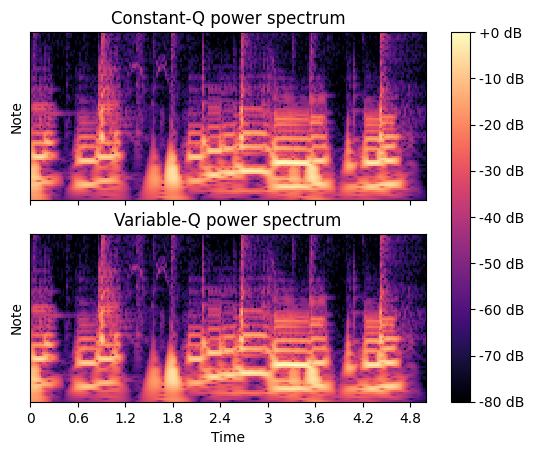

In [ ]:
import matplotlib.pyplot as plt
y, sr = librosa.load(librosa.ex('choice'), duration=5)
gamma = 0.0
C = np.abs(librosa.cqt(y, sr=sr))
V = np.abs(librosa.vqt(y, sr=sr, gamma=gamma))
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=sr, x_axis='time', y_axis='cqt_note', ax=ax[0])
ax[0].set(title='Constant-Q power spectrum', xlabel=None)
ax[0].label_outer()
img = librosa.display.specshow(librosa.amplitude_to_db(V, ref=np.max),
                               sr=sr, x_axis='time', y_axis='cqt_note', ax=ax[1])
ax[1].set_title('Variable-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

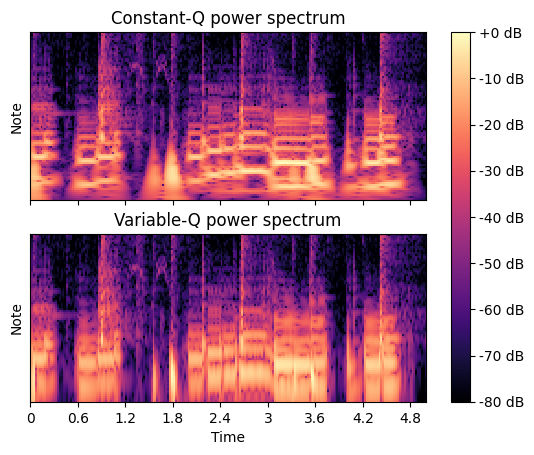

In [ ]:
import matplotlib.pyplot as plt
y, sr = librosa.load(librosa.ex('choice'), duration=5)
C = np.abs(librosa.cqt(y, sr=sr))
V = np.abs(librosa.vqt(y, sr=sr))
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                         sr=sr, x_axis='time', y_axis='cqt_note', ax=ax[0])
ax[0].set(title='Constant-Q power spectrum', xlabel=None)
ax[0].label_outer()
img = librosa.display.specshow(librosa.amplitude_to_db(V, ref=np.max),
                               sr=sr, x_axis='time', y_axis='cqt_note', ax=ax[1])
ax[1].set_title('Variable-Q power spectrum')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [ ]:
import os
import numpy as np
import librosa
import pandas as pd
from pathlib import Path
import time
import matplotlib.pyplot as plt
import matplotlib # 마이너스 부호 설정용
# import matplotlib.font_manager as fm # PNG 생성 안 하므로 주석 처리
from math import gcd
import re
import multiprocessing
from functools import partial
import math # 청크 크기 계산용
import shutil # 👈 파일/폴더 복사를 위해 추가
import traceback # 👈 자세한 오류 추적을 위해 추가

# --- [ 1. 폰트 설정 (영문 사용으로 불필요) ] ---
plt.rcParams['axes.unicode_minus'] = False
# print("ℹ️ 플롯 레이블은 영문으로 표시됩니다.")
font_prop = None # PNG 생성 안 하므로 None

# --- [ 2. 사용자 설정 ] ---
# 🚨 Google Drive 경로 (데이터 원본 및 최종 저장 위치)
DRIVE_ROOT_INPUT = Path("/content/drive/MyDrive/2학기프로젝트/jeuni/Re심전도 데이터/re_npy10초분할_논문방식_v2_Training_set_I") # <- 114,448개 npy + 719개 csv 있는 곳
DRIVE_OUT = Path("/content/drive/MyDrive/2학기 프로젝트/jeuni/Re심전도 데이터/re_npyCQT변환_논문방식v2_Training_set_I") # <- 최종 결과 저장할 곳

# 💡 Colab 로컬 경로 (빠른 처리를 위해 사용)
LOCAL_ROOT_INPUT = Path("/content/local_input_data")
LOCAL_OUT = Path("/content/local_output_cqt")

# ⚡️ 속도 최적화: PNG 생성 안 함
MAX_PNG_FILES_TO_SAVE = 0

# 사용할 CPU 코어 수 (None이면 자동)
NUM_WORKERS = None # Colab 환경에 맞춰 자동 설정 (보통 2개 이상)

# 💡 병렬 처리 효율성을 위한 청크 크기
CHUNK_SIZE = 50 # 로컬 I/O는 빠르므로 청크 크기를 더 늘려도 괜찮음 (메모리 부족 시 줄이기)

# --- [ 3. CQT 파라미터 (이전과 동일) ] ---
INPUT_FS = 200.0
TARGET_FS = None
FMIN = 0.5
FMAX = 50.0
BINS_PER_OCT = 12
HOP_SEC = 0.01
USE_VQT = True
POWER_DB = True
MIN_DURATION_SEC = 9.9 # 10초(2000샘플)에 대한 마진

# --- [ 4. 헬퍼 함수 (ensure_dir, compute_cqt_mag - 이전과 동일) ] ---
def ensure_dir(p: Path): p.mkdir(parents=True, exist_ok=True)

def compute_cqt_mag(x: np.ndarray, fs: float):
    hop_length = max(1, int(round(HOP_SEC * fs)))
    n_oct = np.log2(FMAX / FMIN)
    n_bins = int(np.ceil(n_oct * BINS_PER_OCT))
    if USE_VQT and hasattr(librosa, "vqt"):
        C = librosa.vqt(x.astype(float), sr=fs, hop_length=hop_length, fmin=FMIN, n_bins=n_bins, bins_per_octave=BINS_PER_OCT, gamma=0.0, pad_mode="reflect")
    else: # Fallback or if USE_VQT is False
        C = librosa.cqt(x.astype(float), sr=fs, hop_length=hop_length, fmin=FMIN, n_bins=n_bins, bins_per_octave=BINS_PER_OCT, pad_mode="reflect")
    S = np.abs(C) ** 2
    if POWER_DB: S_db = librosa.power_to_db(S, ref=np.max); return S_db, fs, hop_length, n_bins
    else: return S, fs, hop_length, n_bins

# save_spectrogram_image 함수는 MAX_PNG_FILES_TO_SAVE = 0 이므로 호출되지 않음 (코드 유지)
def save_spectrogram_image(S: np.ndarray, out_png: Path, fs: float, hop_length: int, font_prop=None):
    # ... (이전과 동일, 영문 레이블 사용) ...
    pass # 실제로는 호출 안 됨

# --- [ 💡 5. 병렬 처리용 작업 함수 (강화된 로깅, 경로 수정) 💡 ] ---
# 반환 코드 (이전과 동일)
def process_chunk_worker(chunk_tasks):
    results = []
    pid = os.getpid()
    for task_args in chunk_tasks:
        npy_path, csv_path, output_root, save_png, font_prop, root_base_path = task_args # root_base_path 추가됨
        made_files = 0
        result_code = -99
        log_prefix = f"[PID:{pid}] {npy_path.name}:" # 로그용

        try:
            fs = INPUT_FS # CSV 읽기 실패해도 기본값 사용
            try:
                meta_df = pd.read_csv(csv_path)
                if 'fs' in meta_df.columns:
                     fs_from_csv = float(meta_df['fs'].iloc[0])
                     if abs(fs_from_csv - INPUT_FS) > 1e-3: pass # 경고 없이 INPUT_FS 사용
            except Exception as e_csv:
                 # CSV 읽기 실패 시에도 일단 진행 (INPUT_FS 사용)
                 # print(f"{log_prefix} CSV read warning: {e_csv}. Using default FS.", flush=True)
                 pass # CSV 오류는 치명적이지 않다고 간주 (fs=200 가정)

            try:
                signal_1d = np.load(npy_path).astype(float)
                if signal_1d.ndim != 1: signal_1d = signal_1d.flatten()
                if signal_1d.ndim != 1: result_code = -2; raise ValueError("Flatten failed")
            except Exception as e_npy:
                result_code = -2; raise

            num_samples = len(signal_1d)
            min_required_samples = int(MIN_DURATION_SEC * fs) # fs=200 기준 약 1980
            if num_samples < min_required_samples:
                result_code = 0; raise StopIteration(f"Signal too short: {num_samples} samples")

            try:
                S_db, fs_eff, hop_length, n_bins = compute_cqt_mag(signal_1d, fs)
            except Exception as e_cqt:
                result_code = -3; raise

            # 출력 경로 (로컬 경로 기준)
            segment_stem = npy_path.stem
            relative_path = npy_path.parent.relative_to(root_base_path) # 👈 로컬 경로 기준
            output_dir = output_root / relative_path # 클래스 폴더
            ensure_dir(output_dir)

            # NPY 저장
            try:
                npy_out_name = f"{segment_stem}_cqt_ch0.npy"
                npy_out_path = output_dir / npy_out_name
                np.save(npy_out_path, S_db.astype(np.float32))
                made_files += 1
            except Exception as e_npy_save:
                result_code = -4; raise

            # PNG 저장 (호출 안 됨)
            if save_png: pass # Do nothing if MAX_PNG_FILES_TO_SAVE is 0

            result_code = made_files # 성공 (1)

        except StopIteration: result_code = 0 # 길이 미달
        except Exception as e_proc:
            # 오류 발생 시 상세 traceback 출력
            print(f"--- Worker Error Log (PID:{pid}, File:{npy_path.name}) ---", flush=True)
            traceback.print_exc()
            print(f"--- End Error Log ---", flush=True)
            # result_code는 이미 설정됨

        results.append(result_code)
    return results
# ------------------------------------

# --- [ 💡 6. 메인 실행 함수 (로컬 복사/처리/결과 복사) 💡 ] ---

def main():
    main_start_time = time.time() # 전체 시작 시간

    # --- 1. 데이터 로컬로 복사 ---
    print(f"🚚 Google Drive에서 로컬 저장소로 데이터 복사 시작...")
    print(f"   원본: {DRIVE_ROOT_INPUT}")
    print(f"   대상: {LOCAL_ROOT_INPUT}")
    copy_start_time = time.time()
    try:
        if LOCAL_ROOT_INPUT.exists():
             print(f"   '{LOCAL_ROOT_INPUT}' 폴더가 이미 존재합니다. 삭제 후 다시 복사합니다.")
             shutil.rmtree(LOCAL_ROOT_INPUT) # 기존 로컬 데이터 삭제
        shutil.copytree(DRIVE_ROOT_INPUT, LOCAL_ROOT_INPUT, dirs_exist_ok=True) # dirs_exist_ok=True 필요
        copy_end_time = time.time()
        print(f"✅ 데이터 복사 완료 ({copy_end_time - copy_start_time:.2f} 초)")
    except Exception as e_copy:
        print(f"❌ 데이터 복사 실패: {repr(e_copy)}")
        print("   Google Drive 경로 또는 접근 권한, 로컬 디스크 공간을 확인하세요.")
        return # 복사 실패 시 중단
    # ---------------------------

    cqt_start_time = time.time() # CQT 변환 시작 시간

    # --- 2. 로컬 경로에서 파일 검색 및 처리 ---
    try:
        print(f"\n입력 파일 검색 중 (로컬): {LOCAL_ROOT_INPUT}") # 👈 로컬 경로
        npy_files = sorted(LOCAL_ROOT_INPUT.rglob("*_bp_seg*.npy")) # 👈 로컬 경로
        print(f"총 {len(npy_files)}개의 '*_bp_seg*.npy' 파일을 찾았습니다.")
    except Exception as e:
        print(f"[치명적 오류] .npy 파일 검색 중 오류 ({LOCAL_ROOT_INPUT}): {repr(e)}")
        return
    if not npy_files: print(f"[오류] 로컬 경로 '{LOCAL_ROOT_INPUT}'에서 파일을 찾을 수 없습니다."); return

    print(f"CQT 변환 시작 (병렬 처리, 청크={CHUNK_SIZE}, 최대 PNG={MAX_PNG_FILES_TO_SAVE})...")
    seg_regex = re.compile(r"_seg\d+")
    all_tasks = []; png_saved_count_in_main = 0
    missing_csv_in_main = 0; invalid_name_in_main = 0

    print("CSV 파일 매칭 및 작업 목록 생성 중...")
    for npy_file in npy_files: # npy_file은 이제 로컬 경로
        base_name_match = re.match(r"^(.*)_bp_seg\d+$", npy_file.stem)
        if not base_name_match: invalid_name_in_main += 1; continue
        record_name = base_name_match.group(1)
        csv_name = f"{record_name}_events_seg000.csv"
        csv_file = npy_file.parent / csv_name # 로컬 경로의 CSV
        if not csv_file.exists(): missing_csv_in_main += 1; continue
        save_png_flag = False # MAX_PNG_FILES_TO_SAVE = 0 이므로 항상 False
        # 🚨 task 인자: 로컬 npy 경로, 로컬 csv 경로, 로컬 출력 루트, PNG플래그, 폰트, 로컬 입력 루트
        all_tasks.append((npy_file, csv_file, LOCAL_OUT, save_png_flag, font_prop, LOCAL_ROOT_INPUT)) # 👈 로컬 경로 사용

    total_valid_tasks = len(all_tasks)
    print(f"총 {total_valid_tasks}개의 유효 작업 생성 완료 (제외: CSV:{missing_csv_in_main}, 이름:{invalid_name_in_main}).")
    if not all_tasks: return

    chunks = [all_tasks[i:i + CHUNK_SIZE] for i in range(0, total_valid_tasks, CHUNK_SIZE)]
    num_chunks = len(chunks); print(f"{num_chunks}개의 청크로 분할 완료.")

    # --- 병렬 처리 실행 ---
    all_results = []; processed_files_count = 0
    try:
        n_workers = NUM_WORKERS if NUM_WORKERS is not None else os.cpu_count()
        if n_workers is None: n_workers = 2 # cpu_count() 실패 시 기본값
        print(f"{n_workers}개의 워커 프로세스로 병렬 처리 시작 (총 {num_chunks}개 청크)...")
        with multiprocessing.Pool(processes=n_workers) as pool:
            # imap_unordered 사용 및 진행률 표시 (5% 단위 또는 5000개 단위)
            report_interval = max(1000, total_valid_tasks // 20) # 약 5% 단위
            for chunk_result_list in pool.imap_unordered(process_chunk_worker, chunks):
                all_results.extend(chunk_result_list)
                processed_files_count += len(chunk_result_list)
                if processed_files_count % report_interval == 0 or processed_files_count == total_valid_tasks:
                     progress = (processed_files_count / total_valid_tasks) * 100
                     current_time = time.time(); elapsed = current_time - cqt_start_time
                     print(f"  진행률: {processed_files_count}/{total_valid_tasks} ({progress:.1f}%) - CQT 경과 시간: {elapsed:.2f} 초", flush=True)
        print("병렬 처리 완료.")
    except Exception as e_pool:
        print(f"[치명적 오류] 병렬 처리 중 오류 발생: {repr(e_pool)}")
        traceback.print_exc() # 풀 자체 오류 시 traceback 출력
    # ---------------------

    cqt_end_time = time.time()

    # --- 3. 결과 로컬에서 Drive로 복사 ---
    print(f"\n🚚 로컬 저장소에서 Google Drive로 결과 복사 시작...")
    print(f"   원본: {LOCAL_OUT}")
    print(f"   대상: {DRIVE_OUT}")
    copy_back_start_time = time.time()
    copy_success = False
    try:
        if LOCAL_OUT.exists(): # 로컬 결과 폴더가 있는지 확인
             # 대상 Drive 폴더가 없으면 생성
             ensure_dir(DRIVE_OUT)
             # shutil.copytree(LOCAL_OUT, DRIVE_OUT, dirs_exist_ok=True) # Python 3.8+
             # 하위 호환성 및 Colab 환경 고려하여 rsync 명령어 사용 시도 (더 빠름)
             print("   rsync를 사용하여 복사 시도 중...")
             rsync_cmd = f"rsync -av --progress '{LOCAL_OUT}/' '{DRIVE_OUT}/'"
             os.system(rsync_cmd) # rsync 실행 (Colab 기본 포함)
             # 만약 rsync 실패 시 shutil 사용 (느릴 수 있음)
             # if os.system(rsync_cmd) != 0:
             #      print("   rsync 실패. shutil.copytree 사용 시도 중...")
             #      shutil.copytree(LOCAL_OUT, DRIVE_OUT, dirs_exist_ok=True)
             copy_back_end_time = time.time()
             print(f"✅ 결과 복사 완료 ({copy_back_end_time - copy_back_start_time:.2f} 초)")
             copy_success = True
        else:
             print("   [주의] 로컬 결과 폴더가 생성되지 않았습니다. 복사할 내용이 없습니다.")
             copy_back_end_time = copy_back_start_time # 시간 0으로 처리

    except Exception as e_copy_back:
        copy_back_end_time = time.time()
        print(f"❌ 결과 복사 실패: {repr(e_copy_back)}")
        print(f"   결과는 로컬 '{LOCAL_OUT}'에 남아있을 수 있습니다. 수동으로 복사하세요.")
    # ---------------------------

    # --- 4. 로컬 임시 데이터 삭제 ---
    print("\n🧹 로컬 임시 데이터 삭제 중...")
    delete_start_time = time.time()
    try:
        if LOCAL_ROOT_INPUT.exists(): shutil.rmtree(LOCAL_ROOT_INPUT)
        if LOCAL_OUT.exists(): shutil.rmtree(LOCAL_OUT)
        delete_end_time = time.time()
        print(f"✅ 로컬 임시 데이터 삭제 완료 ({delete_end_time - delete_start_time:.2f} 초).")
    except Exception as e_clean:
        delete_end_time = delete_start_time
        print(f"   [주의] 로컬 임시 데이터 삭제 실패: {e_clean}")
    # ------------------------------------

    # --- 5. 최종 요약 (결과 집계는 이전과 동일) ---
    total_files_created = 0; total_png_saved = 0; skipped_short_count = 0
    csv_error_count = 0; npy_error_count = 0; cqt_error_count = 0
    npy_save_error_count = 0; png_save_error_count = 0; other_error_count = 0
    for res_code in all_results:
        if res_code > 0: total_files_created += res_code;
        if res_code == 2: total_png_saved += 1
        elif res_code == 0: skipped_short_count += 1
        elif res_code == -1: csv_error_count += 1;
        elif res_code == -2: npy_error_count += 1
        elif res_code == -3: cqt_error_count += 1;
        elif res_code == -4: npy_save_error_count += 1
        elif res_code == -5: total_files_created += 1; png_save_error_count += 1
        elif res_code == -99: other_error_count += 1
    successful_npy_count = sum(1 for r in all_results if r > 0 or r == -5)
    main_end_time = time.time()
    total_elapsed_time = main_end_time - main_start_time
    cqt_elapsed_time = cqt_end_time - cqt_start_time

    print(f"\n\n===== CQT 변환 및 복사 완료 =====")
    print(f"총 {total_valid_tasks}개 유효 NPY 처리 시도 / {successful_npy_count}개 NPY 성공 (추정).")
    print(f"총 {total_files_created}개 파일(NPY:{successful_npy_count}, PNG:{total_png_saved}) 생성.")
    print(f"\n[실패/건너뜀 요약]")
    print(f"  - 사전 제외(CSV/이름): {missing_csv_in_main + invalid_name_in_main} 개")
    print(f"  - 길이 미달: {skipped_short_count} 개")
    print(f"  - 오류 (CSV:{csv_error_count}, NPY읽기:{npy_error_count}, CQT:{cqt_error_count}, NPY저장:{npy_save_error_count}, PNG:{png_save_error_count}, 기타:{other_error_count})")
    print(f"\n[소요 시간]")
    print(f"  - 데이터 로컬 복사: {copy_end_time - copy_start_time:.2f} 초")
    print(f"  - CQT 변환 (병렬): {cqt_elapsed_time:.2f} 초")
    if copy_success: print(f"  - 결과 Drive 복사: {copy_back_end_time - copy_back_start_time:.2f} 초")
    else: print(f"  - 결과 Drive 복사: 실패")
    if delete_end_time > delete_start_time: print(f"  - 로컬 데이터 삭제: {delete_end_time - delete_start_time:.2f} 초")
    print(f"  - 총 실행 시간: {total_elapsed_time:.2f} 초")
    print(f"\n최종 결과 저장 경로: {DRIVE_OUT}")
# ------------------------------------

# --- [ 7. 스크립트 실행 ] ---
if __name__ == "__main__":
    # Google Drive 마운트 확인 (Colab 환경 가정)
    if not Path("/content/drive/MyDrive").exists():
         print("⚠️ Google Drive가 마운트되지 않았습니다. 먼저 마운트해주세요.")
         # from google.colab import drive
         # drive.mount('/content/drive') # 필요시 주석 해제
    elif not (DRIVE_ROOT_INPUT.exists() and DRIVE_ROOT_INPUT.is_dir()):
        print(f"[오류] 원본 데이터 폴더(Drive)를 찾을 수 없습니다: {DRIVE_ROOT_INPUT}")
    else:
        main()

🚚 Google Drive에서 로컬 저장소로 데이터 복사 시작...
   원본: /content/drive/MyDrive/2학기프로젝트/jeuni/Re심전도 데이터/re_npy10초분할_논문방식_v2_Training_set_I
   대상: /content/local_input_data
